<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/Nancy_notebook/Efficientnet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [12]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

# Import Tensor Flow and necessary libvraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from PIL import ImageFile

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential

# others
import os, gc, time, pathlib
import tqdm, re, json
import imghdr
seed=24
image_size = (180, 180)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import functools
import math

from absl import logging
import numpy as np
import six
from six.moves import xrange
import tensorflow.compat.v1 as tf

#import utils
#from condconv import condconv_layers
# pre-trained model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image_dataset_from_directory


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **#1 Loading Data **

In [13]:

# environmental variables
TRAIN_DATA_PATH = '/content/drive/MyDrive/MMAI_Train/'
VALID_DATA_PATH = '/content/drive/MyDrive/MMAI_valid/'


CLASS_NAMES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASS_NAMES)

This code is used to check the images before do some edition

In [ ]:

# audit: make sure we have 25,851 images in train and 6,684 images in valid
train_len, test_len = 0, 0
TRAIN_DATA_PATH_GDRIVE = '/content/drive/MyDrive/MMAI_Train/'
VALID_DATA_PATH_GDRIVE = '/content/drive/MyDrive/MMAI_valid'

for f in os.listdir(TRAIN_DATA_PATH_GDRIVE):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH_GDRIVE, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH_GDRIVE, f)))

print("{} images in training set".format(train_len))
print("{} images in test set.".format(test_len))
assert train_len == 25851, "Missing images in training set. It should include 25,851 images"
assert test_len == 6684, "Missing images in valid set. It should include 6,684 images"

In [14]:
# checking availability of GPUs/TPUs
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# **Load Data Using a Keras Utility**

Standard way of pulling data is from websit:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Since I already download the file in the googledrive, Only Path is good enough 
#1 it iwll unizpped on "/content"
import pathlib
data = pathlib.Path('/content/folders_inside_zip') 
count = len(list(data.glob('*/*.jpg')))
count
#2 it if it already unziped in google drive
import pathlib
data = pathlib.Path('/content/gdrive/My Drive/TrainingPictures/') 
count = len(list(data.glob('*.jpg')))
count

In [15]:
# environmental variables
path_to_dir_train = "/content/drive/MyDrive/MMAI_Train/"
path_to_dir_valid = "/content/drive/MyDrive/MMAI_valid/"
     

# **STEP#2: Filter Out  Corrupted Images **
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature t

In [ ]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images
     

In [ ]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images

In [ ]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [ ]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)
     

# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)
     

# check image quality 3
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train3 = image_quality_check3(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test3 = image_quality_check3(VALID_DATA_PATH)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs
-------------------- check training set image quality. --------------------
-------------------- check test and validation set image quality. --------------------
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|████████████████████████████████████████| 1004/1004 [00:00<00:00, 1232.07file/s]


-------------------- check test and validation set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████████| 252/252 [00:00<00:00, 1304.39file/s]


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████| 1004/1004 [00:00<00:00, 428216.52file/s]


-------------------- check test and validation set image quality. --------------------


powdery_mildew         : 100%|████████████████████████████████████████| 252/252 [00:00<00:00, 503316.48file/s]


In [ ]:

move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))
     

# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)


Move 0 images with bad quality.
25836
6677


# Number of Images **Remains**

In [16]:
# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25836
6677


In [ ]:
del image_quality_check, image_quality_check2, image_quality_check3, bad_images_train, bad_images_val_test, bad_images_train2, bad_images_val_test2, bad_images_train3, bad_images_val_test3
gc.collect()

# **STEP#3: **Load Dataset **
We will use high-level Keras preprocessing utilities (such as tf.keras.utils.image_dataset_from_directory) and layers (such as tf.keras.layers.Rescaling) to read a directory of images on disk.

image_dataset_from_directory returns a tf.data.Dataset object, a tuple (images, labels), where images has shape is (batch_size, image_size[0], image_size[1], num_channels).
supported image formats: jpeg, png, bmp, gif
Reference:

tf.keras.utils.image_dataset_from_directory

In [18]:
## Define some parameters for the loader
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH =224
img_height, img_width =224,224
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'
batch_size=32

In [19]:

# training set - expect 25,851 (25,835) images
train_ds = keras.utils.image_dataset_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        labels='inferred',
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed
        )

Found 25835 files belonging to 11 classes.


In [20]:

# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        VALID_DATA_PATH,
        batch_size =batch_size , 
        image_size = (img_height, img_width), 
        label_mode='categorical' ,
        color_mode='rgb' ,
        shuffle=True,
        seed = 123,
        validation_split = 0.5, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [21]:
# Save class names and mappings between label_id vs class
CLASS_NAMES = test_ds.class_names
CLASS_NAMES_TF = {k: v for v, k in enumerate(CLASS_NAMES)}
print(CLASS_NAMES)
print(CLASS_NAMES_TF)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


In [22]:
# audit - make sure validation and test sets are approximately follow same distributi
assert ((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test do not match'

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 11)


In [24]:
# check number of batches
print('train dataset size: ' + str(train_ds.cardinality().numpy()))
print('valid dataset size: ' + str(valid_ds.cardinality().numpy()))
print('test dataset size: ' + str(test_ds.cardinality().numpy()))

train dataset size: 808
valid dataset size: 105
test dataset size: 105


# **Visualize the Data**
Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".

Data Preprocessing 
image preprocessing layers: standardizing the inputs of an image model
when you export your model using model save, the preprocessing layrers will be saved a

## Using Image Data Augmentation 
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [25]:
data_augmentation = keras.Sequential(
    [
      # make model more tolerate to variations in position 
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), seed=seed),     
      layers.RandomRotation(0.1, seed = seed),  # randomly rotates images during training
      layers.RandomZoom(0.1, seed = seed),      # randomly flips images during training
      layers.RandomTranslation(height_factor=0.15, width_factor=0.15, seed = seed),  # random geometric translation
     
      # make model more tolerate to different lighting conditions 
      layers.RandomContrast(0.15, seed = seed),       #randomly adjusts contrast during training
      layers.RandomBrightness(factor=0.2, seed=seed)  #randomly increase/decrease brightness during training
    ], name = 'data_augmentation'
)
     

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

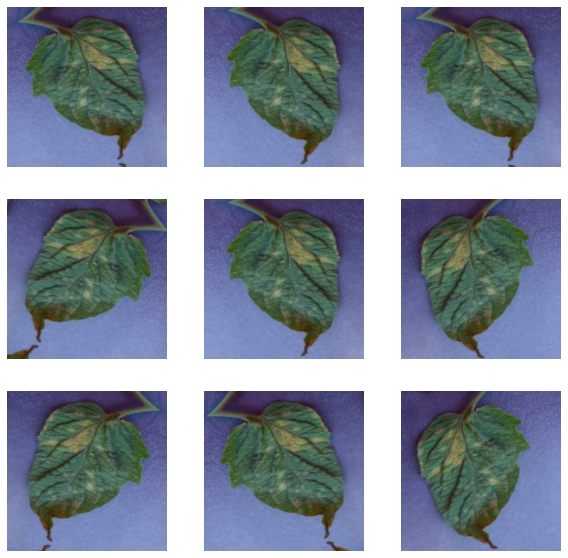

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Configure the dataset for performance

Autotun to traning images

In [28]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [29]:

augment = True

if augment:
  train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# **Data preprecessing for the model **
Once we verfity the input data augmention are working correctly, we parepare dataset for training. The input data resized to uniform img_size. The labes are put into one-hot(a.k.a categorical) encoding. 
# Note: each Keras Application expects a specific kind of input preprocessing. For EfficientNet, **input preprocessing is included as part of the model **(as a Rescaling layer), and thus tf.keras.applications.efficientnet.preprocess_input is actually a pass-through function. EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range. Users are* no longer required* to call this method to normalize the input data. This method does nothing and only kept as a placeholder to align the API surface between old and new version of model.



# **EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks**

Convolutional Neural Networks (ConvNets) are commonly developed at a fixed resource budget, and then scaled up for better accuracy if more resources are available. In this paper, we systematically study model scaling and identify that carefully balancing network depth, width, and resolution can lead to better performance. Based on this observation, we propose a new scaling method that uniformly scales all dimensions of depth/width/resolution using a simple yet highly effective compound coefficient. We demonstrate the effectiveness of this method on scaling up MobileNets and ResNet.

To go even further, we use neural architecture search to design a new baseline network and scale it up to obtain a family of models, called EfficientNets, which achieve much better accuracy and efficiency than previous ConvNets. In particular, our EfficientNet-B7 achieves state-of-the-art 84.3% top-1 accuracy on ImageNet, while being 8.4x smaller and 6.1x faster on inference than the best existing ConvNet. Our EfficientNets also transfer well and achieve state-of-the-art accuracy on CIFAR-100 (91.7%), Flowers (98.8%), and 3 other transfer learning datasets, with an order of magnitude fewer parameters. Source code is at this https URL.

In [36]:
history = model.fit(train_ds, epochs=2, validation_data=valid_ds)

Epoch 1/2
808/808 [==============================] - 975s 1s/step - loss: 0.4637 - accuracy: 0.8474 - val_loss: 0.6744 - val_accuracy: 0.8362
Epoch 2/2
808/808 [==============================] - 912s 1s/step - loss: 0.2524 - accuracy: 0.9170 - val_loss: 0.2533 - val_accuracy: 0.9203
